In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import os, math, random, numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import sys
import h5py
from pathlib import Path
import zipfile, os, sys
from collections import defaultdict, Counter
import re
import json
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import random
from statistics import mean
from torch.optim.lr_scheduler import LambdaLR

os.environ["TQDM_NOTEBOOK"] = "0"

ROOT = Path.cwd().parent          
SRC  = ROOT / "src"
sys.path.insert(0, str(SRC))     

from fashiongen_h5_loader import (
    ensure_h5_ready, build_vocab_from_h5, build_material_vocab_from_h5, make_loaders_with_existing_val, read_label_ids_from_h5, fast_material_counts

)

# v1: the backbone/existing code (kept unchanged)
from multitask_fashion_model_v1 import (
    FashionMultiTaskModel, MultiTaskConfig, collate_batch, TextTokenizer, worker_init_fn
)

# v2: extras 
from multitask_fashion_model_v2.losses import LabelSmoothingCE, FocalLoss
from multitask_fashion_model_v2.aug import mixup_or_cutmix, _mixup_crit
from multitask_fashion_model_v2.patch_pool import MaterialSidecar, PatchAttentionPool
from multitask_fashion_model_v2.balance import MovingAverageLossScaler
from multitask_fashion_model_v2 import decoding as dec
from multitask_fashion_model_v2.step import train_one_step
from multitask_fashion_model_v2.evaluate import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


# 1. Set Seed

In [3]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); 
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2. Import Data and Map

In [4]:
DATA_DIR = ROOT / "data"
assert DATA_DIR.exists(), f"Missing data dir: {DATA_DIR}"
print("DATA_DIR:", DATA_DIR)

DATA_DIR: /home/jiaqing/codebase/Shop-Till-You-Drop/data


In [5]:
train_h5 = DATA_DIR / "fashiongen_256_256_train.h5" / "fashiongen_256_256_train.h5"
val_h5   = DATA_DIR / "fashiongen_256_256_validation.h5" / "fashiongen_256_256_validation.h5"
print("train_h5:", train_h5)
print("val_h5  :", val_h5)


train_h5: /home/jiaqing/codebase/Shop-Till-You-Drop/data/fashiongen_256_256_train.h5/fashiongen_256_256_train.h5
val_h5  : /home/jiaqing/codebase/Shop-Till-You-Drop/data/fashiongen_256_256_validation.h5/fashiongen_256_256_validation.h5


In [6]:
label_vocab_path = ROOT / "artifacts/label_vocab.json"
gender_vocab_path = ROOT / "artifacts/gender_vocab.json"
mat_vocab_path = ROOT / "artifacts/material_vocab.json"

In [7]:
# Build id → name map
with open(label_vocab_path) as f:
    label_vocab = json.load(f)
    
id2label = {int(v): k for k, v in label_vocab.items()}

In [8]:
with open(gender_vocab_path) as f:
    gen_vocab = json.load(f)
id2gen = {int(v): k for k, v in gen_vocab.items()}

In [9]:
with open(mat_vocab_path) as f:
    mat_vocab = json.load(f)
id2mat = {int(v): k for k, v in mat_vocab.items()}

In [10]:
META_KEYS = ("input_category", "input_name", "input_description", "input_gender")  

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders_with_existing_val(
    train_h5=train_h5,
    val_h5=val_h5,
    vocab_label_json=str(label_vocab_path),
    vocab_gender_json=str(gender_vocab_path),
    material_vocab_json=str(mat_vocab_path),    
    composition_key="input_composition",
    materials_clothing_only=True,
    image_key="input_image",
    label_key="input_category",
    caption_key_candidates=("input_name","input_description","input_concat_description","caption","descriptions"),
    label_key_candidates=("input_category","category","class","label"),
    meta_keys=META_KEYS,
    meta_prefix="input_",
    image_size=224,
    train_ratio=0.8,
    batch_size=64,
    num_workers=8,
    normalize="imagenet",
)
print("train/val/test lens:", len(train_ds), len(val_ds), len(test_ds))

train/val/test lens: 208383 32528 52107


In [11]:
print("image_key:", train_ds.image_key)
print("label_key:", train_ds.label_key)
print("caption_key:", train_ds.caption_key)
print("composition_key:", train_ds.composition_key)

image_key: input_image
label_key: input_category
caption_key: input_name
composition_key: input_composition


In [12]:
b = next(iter(train_loader))

In [13]:
print(b["image"].shape, b["label"].shape, b['gender'].shape, b['material'].shape)

torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64]) torch.Size([64])


In [14]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_img(img_t: torch.Tensor, norm="imagenet"):
    if norm == "imagenet":
        x = img_t * IMAGENET_STD + IMAGENET_MEAN
    elif norm == "gan":
        x = (img_t * 0.5) + 0.5
    else:
        x = img_t
    return x.clamp(0,1)

def show_samples(ds, idxs=None, n=8, ncols=4, norm="imagenet", id2label=None, figsize=(14, 8)):
    """
    idxs refer to **dataset indices**: 0..len(ds)-1.
    If idxs is None, we sample uniformly from that range.
    """
    N = len(ds)
    if idxs is None:
        n = min(n, N)
        idxs = np.random.default_rng(0).choice(np.arange(N), size=n, replace=False)
    else:
        idxs = [int(i) for i in idxs]
        for i in idxs:
            if not (0 <= i < N):
                raise IndexError(f"Dataset index {i} out of range [0, {N})")

    n = len(idxs)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols

    plt.figure(figsize=figsize)
    for pos, i in enumerate(idxs, 1):
        ex = ds[i]  # safe: dataset index
        img = denorm_img(ex["image"], norm=norm).permute(1,2,0).cpu().numpy()
        y = ex["label"]
        yname = id2label.get(int(y), str(y)) if id2label is not None else str(y)
        cap = ex.get("caption", "")
        cap = cap if isinstance(cap, str) else str(cap)
        if len(cap) > 80: cap = cap[:80] + "…"

        ax = plt.subplot(nrows, ncols, pos)
        ax.imshow(img); ax.axis("off")
        ax.set_title(f"{y} | {yname}", fontsize=10)
        ax.set_xlabel(cap, fontsize=9)
    plt.tight_layout()
    plt.show()

def show_by_raw_index(ds, raw_idxs, **kw):
    """
    Peek items by **raw H5 indices** (values inside ds.keep_idx).
    We convert each raw index to its dataset index first.
    """
    raw_idxs = [int(r) for r in raw_idxs]
    keep = np.asarray(ds.keep_idx)
    inv = {int(k): j for j, k in enumerate(keep)}  # raw->dataset
    ds_idxs = []
    missing = []
    for r in raw_idxs:
        j = inv.get(int(r))
        if j is None:
            missing.append(r)
        else:
            ds_idxs.append(j)
    if missing:
        print(f"(skipped {len(missing)} raw indices not in subset): {missing[:10]}")
    return show_samples(ds, idxs=ds_idxs, **kw)

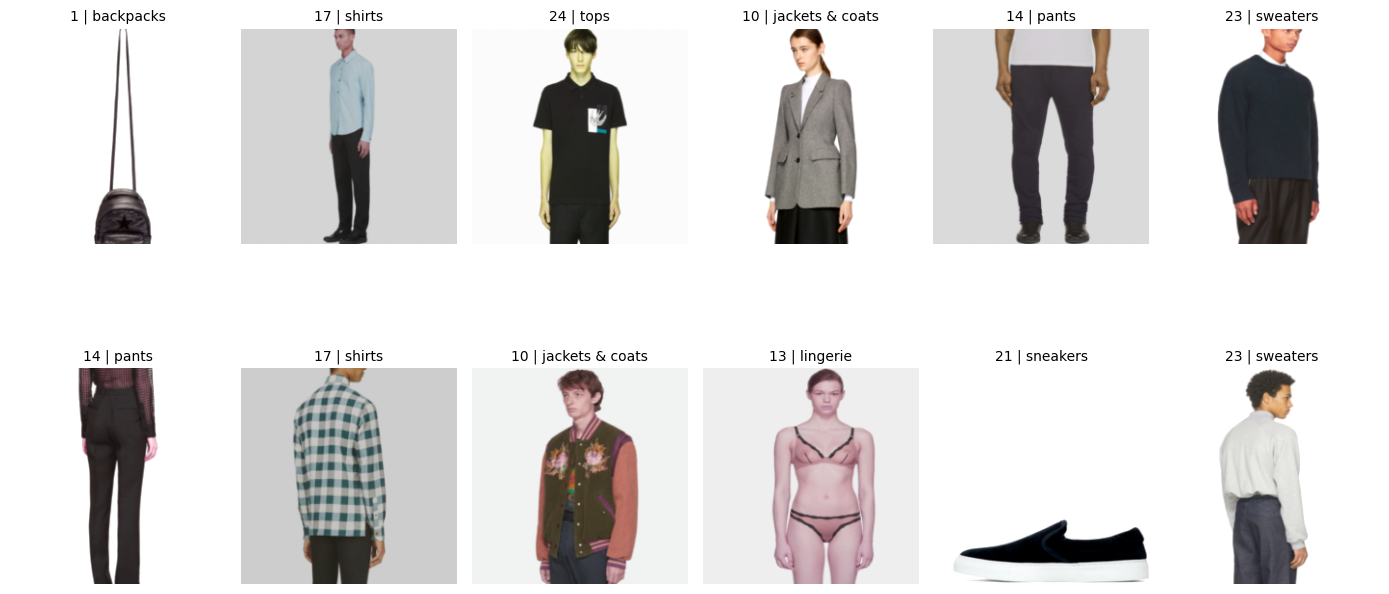

In [15]:
show_samples(train_ds, n=12, ncols=6, norm="imagenet", id2label=id2label)

# 2. Build the Model

In [16]:
# 1) Build tokenizer from the train dataset captions
# captions = [train_ds[i]["caption"] for i in tqdm(range(len(train_ds)))]

In [17]:
# tok =  TextTokenizer.build_from_captions(captions=captions, min_freq=2, max_size=30000)

In [18]:
import json, os
# os.makedirs("artifacts", exist_ok=True)
# with open("artifacts/tokenizer.json","w") as f:
#     json.dump({"stoi": tok.stoi}, f)

# load later
with open("artifacts/tokenizer.json") as f:
    stoi = json.load(f)["stoi"]
tok = TextTokenizer(stoi)

In [19]:
print(len(tok.stoi), list(tok.stoi)[:10])

13373 ['<pad>', '<bos>', '<eos>', '<unk>', 'black', 'white', 't-shirt', '&', 'jacket', 'grey']


In [25]:
## 2) Create model config (enable/disable heads based on vocabs)
cfg = MultiTaskConfig(
    backbone="vit_base_patch16_224",
    proj_dim=512,
    num_categories=len(label_vocab),
    num_genders=len(gen_vocab),
    num_materials=len(mat_vocab), 
    vocab_size=len(tok.stoi),
    pad_id=tok.pad_id,
    caption_emb_dim=256,
    caption_layers=1,
    dropout=0.1,
    loss_w_category=1.0,
    loss_w_gender=0.5,
    loss_w_material=2.0,
    loss_w_caption=1.3,
)

model = FashionMultiTaskModel(cfg).to(device)

USE_SIDE_MATERIAL = True      # small ViT sidecar that pools patch tokens for material
USE_DYNAMIC_BAL   = True      # EMA scaling so one loss head doesn't dominate
MATERIAL_LOSS     = "labelsmooth"  # "ce" | "labelsmooth" | "focal"
MIXUP_P, CUTMIX_P = 0.4, 0.2
DECODE_MODE       = "beam"    # "greedy" | "beam" | "nucleus"
MAX_LEN           = 20

sidecar  = MaterialSidecar(out_dim=cfg.proj_dim).to(device) if USE_SIDE_MATERIAL else None
balancer = MovingAverageLossScaler(warmup_steps=100) if USE_DYNAMIC_BAL else None

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [26]:
# 3) DataLoaders with collate
def collate_with_meta(samples, tokenizer, expect_category, expect_gender, expect_material):
    batch = collate_batch(samples, tokenizer, expect_category, expect_gender, expect_material)
    batch["meta"] = [s.get("meta", {}) for s in samples]
    batch["caption_raw"] = [s.get("caption", "") for s in samples]
    return batch

collate_fn = partial(
    collate_with_meta,          
    tokenizer=tok,
    expect_category=(cfg.num_categories is not None),
    expect_gender=(cfg.num_genders is not None),
    expect_material=(cfg.num_materials is not None),
)


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,  
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,
)

print("Loaders rebuilt with custom collate:",
      len(train_ds), len(val_ds), len(test_ds))

Loaders rebuilt with custom collate: 208383 32528 52107


In [27]:
# 4) Material class weights from training set
mat_counts, missing = fast_material_counts(train_ds)
num_mat = len(train_ds.material_vocab)
counts_material = torch.tensor(
    [mat_counts.get(i, 1) for i in range(num_mat)], dtype=torch.float, device=device
)

def class_weights_from_counts(counts: torch.Tensor):
    w = 1.0 / (counts + 1e-6)
    w = (w / w.sum()) * len(w)   # mean ≈ 1
    return w

material_class_weights = class_weights_from_counts(counts_material)
print("Built material_class_weights:", tuple(material_class_weights.shape), "missing:", missing)

Built material_class_weights: (8,) missing: 0


In [23]:
# Convert vocab id→name
id2mat = {v: k for k, v in mat_vocab.items()}

# Build dense count vector for all materials
all_counts = {id2mat[i]: mat_counts.get(i, 0) for i in range(len(mat_vocab))}

df_mat_all = pd.DataFrame([
    {"material_name": id2mat[i], "count": mat_counts.get(i, 0)}
    for i in range(len(mat_vocab))
]).sort_values("count", ascending=False).reset_index(drop=True)

display(df_mat_all)


,material_name,count
0,cotton,96693
1,leather,34012
2,wool,23430
3,__other__,15420
4,polyester,15141
5,nylon,11703
6,viscose,11599
7,elastane,385


In [28]:
# --------------------------
# Optimizer (param groups)
#   - lower LR on backbone
#   - higher LR on heads/decoder
# --------------------------
backbone_params = list(model.backbone.parameters())
head_params = [p for n, p in model.named_parameters() if not n.startswith("backbone.")]
if sidecar is not None:
    head_params += list(sidecar.parameters())

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-4},
        {"params": head_params,     "lr": 3e-4},
    ],
    weight_decay=1e-4,
    betas=(0.9, 0.98),
)


In [31]:
# --------------------------
# Scheduler: warmup + cosine
# --------------------------

steps_per_epoch = max(1, len(train_loader))
EPOCHS = 10
total_steps  = steps_per_epoch * EPOCHS
warmup_steps = int(0.10 * total_steps)  # 10% warmup

def lr_lambda(step):
    if step < warmup_steps:
        return (step + 1) / float(max(1, warmup_steps))
    t = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1 + math.cos(math.pi * t))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [32]:
# --------------------------
# Freeze backbone
#   (stabilize first 3 epochs)
# --------------------------
def set_backbone_trainable(m, trainable: bool):
    for p in m.backbone.parameters():
        p.requires_grad = trainable

FREEZE_EPOCHS = 3
set_backbone_trainable(model, trainable=False)  # freeze at start

In [33]:
def score_fn(m):
    s = 0.0
    s += 0.5 * m.get("material_top1", 0.0)
    s += 0.3 * m.get("category_top1", 0.0)
    s += 0.2 * m.get("gender_top1", 0.0)
    if "caption_ppl" in m:
        s += 0.2 * (1.0 / (1.0 + m["caption_ppl"]))
    return s

def caption_ppl_inv(m):
    if "caption_ppl" not in m: return 0.0
    return 1.0 / (1.0 + m["caption_ppl"])

def overall_score(m):
    return (m['category_top1'] + m['gender_top1'] + m['material_top1'])/3.0 + (1.0 / max(1e-6, m['caption_ppl']))


In [34]:
best_score = -1e9
patience, bad = 3, 0
BEST_OVERALL = {"score": -float("inf"), "epoch": 0}
BEST_HEADS = {
    "category_top1": {"score": -float("inf"), "epoch": 0},
    "gender_top1":   {"score": -float("inf"), "epoch": 0},
    "material_top1": {"score": -float("inf"), "epoch": 0},
    "caption_ppl_inv": {"score": -float("inf"), "epoch": 0},
}
SCORES = []
_last_val_for_bar = {}


In [ ]:
os.makedirs("runs", exist_ok=True)

# --------------------------
# Training loop
# --------------------------
global_step = 0
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    if epoch == FREEZE_EPOCHS + 1:
        set_backbone_trainable(model, trainable=True)  # unfreeze

    model.train()
    totals = []
    bar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"[Epoch {epoch}/{EPOCHS}]")

    for step, batch in bar:
        logs = train_one_step(
            model, batch, optimizer, tok, device,
            sidecar=sidecar,
            material_loss_kind=MATERIAL_LOSS,
            mixup_p=MIXUP_P, cutmix_p=CUTMIX_P,
            w_cat=cfg.loss_w_category, w_gen=cfg.loss_w_gender,
            w_mat=cfg.loss_w_material, w_cap=cfg.loss_w_caption,
            class_weights_mat=material_class_weights,
            balancer=balancer,
            decode_mode=DECODE_MODE,   # if your train step does any scheduled sampling/aux decode
        )
        totals.append(logs["total"])

        # advance scheduler per-iteration
        global_step += 1
        scheduler.step()

        # lr for display
        lr = max(pg["lr"] for pg in optimizer.param_groups)
        bar_post = {
            "train_total": f"{logs['total']:.3f}",
            "mat": f"{logs.get('material_ce', 0.0):.3f}",
            "cap": f"{logs.get('caption_nll', 0.0):.3f}",
            "lr": f"{lr:.1e}",
            "aug": logs.get("mix_mode", "none"),
        }
        if _last_val_for_bar:
            bar_post.update({
                "v_cat": f"{_last_val_for_bar.get('category_top1',0):.3f}",
                "v_gen": f"{_last_val_for_bar.get('gender_top1',0):.3f}",
                "v_mat": f"{_last_val_for_bar.get('material_top1',0):.3f}",
                "v_ppl": f"{_last_val_for_bar.get('caption_ppl',0):.2f}",
            })
        bar.set_postfix(bar_post)

    avg_total = mean(totals) if totals else float("nan")
    print(f"\n[Epoch {epoch}] train_total={avg_total:.4f}")

    # --------- VALIDATE ----------
    val_metrics = evaluate(
        model, val_loader, tokenizer=tok, device=device,
        decode_mode=DECODE_MODE,  # "beam" uses your beam generator under the hood
        max_len=MAX_LEN
    )
    pretty = {k: (round(v,4) if isinstance(v, float) else v) for k, v in val_metrics.items()}
    print("Val metrics:", pretty)

    _last_val_for_bar = {
        "category_top1": val_metrics.get("category_top1", 0.0),
        "gender_top1":   val_metrics.get("gender_top1", 0.0),
        "material_top1": val_metrics.get("material_top1", 0.0),
        "caption_ppl":   val_metrics.get("caption_ppl", float("inf")),
    }

    record = {"epoch": epoch, **val_metrics}
    record["overall_score"] = score_fn(val_metrics)
    record["caption_ppl_inv"] = caption_ppl_inv(val_metrics)
    SCORES.append(record)
    with open("runs/val_history.jsonl", "a") as f:
        f.write(json.dumps(record) + "\n")

    # best-overall checkpoint
    cur_score = record["overall_score"]
    if cur_score > BEST_OVERALL["score"]:
        BEST_OVERALL.update({"score": cur_score, "epoch": epoch})
        torch.save({"model": model.state_dict(), "cfg": cfg.__dict__, "val_metrics": val_metrics},
                   "runs/best_overall.pt")
        print(f"✅ Saved new BEST OVERALL at epoch {epoch} (overall_score={cur_score:.4f})")
        bad = 0
    else:
        bad += 1
        if bad >= 3:
            print("Early stopping (no overall improvement).")
            break

    # per-head bests
    head_targets = {
        "category_top1": record.get("category_top1", 0.0),
        "gender_top1":   record.get("gender_top1", 0.0),
        "material_top1": record.get("material_top1", 0.0),
        "caption_ppl_inv": record.get("caption_ppl_inv", 0.0),
    }
    for key, val in head_targets.items():
        if val > BEST_HEADS[key]["score"]:
            BEST_HEADS[key].update({"score": val, "epoch": epoch})
            ckpt_path = f"runs/best_{key}.pt"
            torch.save({"model": model.state_dict(), "cfg": cfg.__dict__, "val_metrics": val_metrics}, ckpt_path)
            print(f"Saved new best for {key} at epoch {epoch}: {val:.4f} -> {ckpt_path}")

print(f"\nBest overall: epoch {BEST_OVERALL['epoch']} (score={BEST_OVERALL['score']:.4f})")
print("Best per head:", {k: (v['epoch'], round(v['score'], 4)) for k, v in BEST_HEADS.items()})

[Epoch 1/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 1] train_total=5.1059


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6601, 'gender_top1': 0.8398, 'material_top1': 0.0712, 'caption_nll_per_token': 3.4191, 'caption_ppl': 30.5419, 'BLEU-1': 0.2208, 'BLEU-2': 0.0319, 'BLEU-4': 0.0001, 'ROUGE-L_P': 0.3793, 'ROUGE-L_R': 0.2502, 'ROUGE-L_F1': 0.2954}
✅ Saved new BEST OVERALL at epoch 1 (overall_score=0.4079)
Saved new best for category_top1 at epoch 1: 0.6601 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 1: 0.8398 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 1: 0.0712 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 1: 0.0317 -> runs/best_caption_ppl_inv.pt


[Epoch 2/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 2] train_total=4.7952


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

In [ ]:
os.makedirs("runs", exist_ok=True)

# --- helpers ---
def score_fn(m):  # your overall score
    s = 0.0
    s += 0.5 * m.get("material_top1", 0.0)
    s += 0.3 * m.get("category_top1", 0.0)
    s += 0.2 * m.get("gender_top1", 0.0)
    if "caption_ppl" in m:
        s += 0.2 * (1.0 / (1.0 + m["caption_ppl"]))
    return s

def caption_ppl_inv(m):  # higher is better (inverse ppl)
    if "caption_ppl" not in m: return 0.0
    return 1.0 / (1.0 + m["caption_ppl"])

def overall_score(m):
    # weight the 3 discriminative heads, reward lower ppl
    return (m['category_top1'] + m['gender_top1'] + m['material_top1'])/3.0 + (1.0 / max(1e-6, m['caption_ppl']))

best_score = -1e9
patience, bad = 3, 0
BEST_OVERALL = {"score": -float("inf"), "epoch": 0}
BEST_HEADS = {
    "category_top1": {"score": -float("inf"), "epoch": 0},
    "gender_top1":   {"score": -float("inf"), "epoch": 0},
    "material_top1": {"score": -float("inf"), "epoch": 0},
    "caption_ppl_inv": {"score": -float("inf"), "epoch": 0},
}
SCORES = []  # history

# will hold last val metrics for displaying on next epoch's progress bar
_last_val_for_bar = {}

EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    totals = []
    bar = tqdm(enumerate(train_loader, 1), total=len(train_loader),
               desc=f"[Epoch {epoch}/{EPOCHS}]")

    for step, batch in bar:
        logs = train_one_step(
            model, batch, optimizer, tok, device,
            sidecar=sidecar,
            material_loss_kind=MATERIAL_LOSS,
            mixup_p=MIXUP_P, cutmix_p=CUTMIX_P,
            w_cat=cfg.loss_w_category, w_gen=cfg.loss_w_gender,
            w_mat=cfg.loss_w_material, w_cap=cfg.loss_w_caption,
            class_weights_mat=material_class_weights,
            balancer=balancer,
        )
        totals.append(logs["total"])

        lr = max(pg["lr"] for pg in optimizer.param_groups)
        # include *last epoch's* val snapshot in postfix (if available)
        bar_post = {
            "train_total": f"{logs['total']:.3f}",
            "mat": f"{logs.get('material_ce', 0.0):.3f}",
            "cap": f"{logs.get('caption_nll', 0.0):.3f}",
            "lr": f"{lr:.1e}",
            "aug": logs.get("mix_mode", "none"),
        }
        if _last_val_for_bar:
            bar_post.update({
                "v_cat": f"{_last_val_for_bar.get('category_top1',0):.3f}",
                "v_gen": f"{_last_val_for_bar.get('gender_top1',0):.3f}",
                "v_mat": f"{_last_val_for_bar.get('material_top1',0):.3f}",
                "v_ppl": f"{_last_val_for_bar.get('caption_ppl',0):.2f}",
            })
        bar.set_postfix(bar_post)

    # end of epoch (train summary)
    avg_total = mean(totals) if totals else float("nan")
    print(f"\n[Epoch {epoch}] train_total={avg_total:.4f}")

    # validate
    val_metrics = evaluate(model, val_loader, tokenizer=tok, device=device,
                           decode_mode="beam", max_len=16)
    pretty = {k: (round(v,4) if isinstance(v, float) else v) for k, v in val_metrics.items()}
    print("Val metrics:", pretty)

    # store for next epoch's bar display
    _last_val_for_bar = {
        "category_top1": val_metrics.get("category_top1", 0.0),
        "gender_top1":   val_metrics.get("gender_top1", 0.0),
        "material_top1": val_metrics.get("material_top1", 0.0),
        "caption_ppl":   val_metrics.get("caption_ppl", float("inf")),
    }

    # record history
    record = {"epoch": epoch, **val_metrics}
    record["overall_score"] = score_fn(val_metrics)
    record["caption_ppl_inv"] = caption_ppl_inv(val_metrics)
    SCORES.append(record)

    # save rolling history
    with open("runs/val_history.jsonl", "a") as f:
        f.write(json.dumps(record) + "\n")

    # --- overall best checkpoint ---
    cur_score = record["overall_score"]
    if cur_score > BEST_OVERALL["score"]:
        BEST_OVERALL.update({"score": cur_score, "epoch": epoch})
        torch.save(
            {"model": model.state_dict(), "cfg": cfg.__dict__, "val_metrics": val_metrics},
            "runs/best_overall.pt",
        )
        print(f"✅ Saved new BEST OVERALL at epoch {epoch} (overall_score={cur_score:.4f})")

    # --- per-head best checkpoints ---
    head_targets = {
        "category_top1": record.get("category_top1", 0.0),
        "gender_top1":   record.get("gender_top1", 0.0),
        "material_top1": record.get("material_top1", 0.0),
        "caption_ppl_inv": record.get("caption_ppl_inv", 0.0),  # higher is better
    }
    for key, val in head_targets.items():
        if val > BEST_HEADS[key]["score"]:
            BEST_HEADS[key].update({"score": val, "epoch": epoch})
            ckpt_path = f"runs/best_{key}.pt"
            torch.save(
                {"model": model.state_dict(), "cfg": cfg.__dict__, "val_metrics": val_metrics},
                ckpt_path,
            )
            print(f"Saved new best for {key} at epoch {epoch}: {val:.4f} -> {ckpt_path}")

print(f"\nBest overall: epoch {BEST_OVERALL['epoch']} (score={BEST_OVERALL['score']:.4f})")
print("Best per head:", {k: (v['epoch'], round(v['score'], 4)) for k, v in BEST_HEADS.items()})


[Epoch 1/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 1] train_total=4.6296


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.5359, 'gender_top1': 0.8317, 'material_top1': 0.0995, 'caption_nll_per_token': 3.3129, 'caption_ppl': 27.464, 'BLEU-1': 0.2151, 'BLEU-2': 0.0265, 'BLEU-4': 0.0001, 'ROUGE-L_P': 0.3382, 'ROUGE-L_R': 0.2372, 'ROUGE-L_F1': 0.2738}
✅ Saved new BEST OVERALL at epoch 1 (overall_score=0.3839)
Saved new best for category_top1 at epoch 1: 0.5359 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 1: 0.8317 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 1: 0.0995 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 1: 0.0351 -> runs/best_caption_ppl_inv.pt


[Epoch 2/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 2] train_total=4.4928


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6008, 'gender_top1': 0.8803, 'material_top1': 0.1052, 'caption_nll_per_token': 3.067, 'caption_ppl': 21.4769, 'BLEU-1': 0.233, 'BLEU-2': 0.0304, 'BLEU-4': 0.0002, 'ROUGE-L_P': 0.3615, 'ROUGE-L_R': 0.2562, 'ROUGE-L_F1': 0.2945}
✅ Saved new BEST OVERALL at epoch 2 (overall_score=0.4178)
Saved new best for category_top1 at epoch 2: 0.6008 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 2: 0.8803 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 2: 0.1052 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 2: 0.0445 -> runs/best_caption_ppl_inv.pt


[Epoch 3/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 3] train_total=4.4944


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6264, 'gender_top1': 0.8967, 'material_top1': 0.1135, 'caption_nll_per_token': 2.9772, 'caption_ppl': 19.6327, 'BLEU-1': 0.2481, 'BLEU-2': 0.0361, 'BLEU-4': 0.0003, 'ROUGE-L_P': 0.3755, 'ROUGE-L_R': 0.271, 'ROUGE-L_F1': 0.3094}
✅ Saved new BEST OVERALL at epoch 3 (overall_score=0.4337)
Saved new best for category_top1 at epoch 3: 0.6264 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 3: 0.8967 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 3: 0.1135 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 3: 0.0485 -> runs/best_caption_ppl_inv.pt


[Epoch 4/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 4] train_total=4.4948


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6489, 'gender_top1': 0.9091, 'material_top1': 0.1092, 'caption_nll_per_token': 2.9124, 'caption_ppl': 18.4003, 'BLEU-1': 0.2527, 'BLEU-2': 0.0381, 'BLEU-4': 0.0004, 'ROUGE-L_P': 0.3856, 'ROUGE-L_R': 0.277, 'ROUGE-L_F1': 0.3167}
✅ Saved new BEST OVERALL at epoch 4 (overall_score=0.4414)
Saved new best for category_top1 at epoch 4: 0.6489 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 4: 0.9091 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 4: 0.0515 -> runs/best_caption_ppl_inv.pt


[Epoch 5/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 5] train_total=4.4962


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6659, 'gender_top1': 0.9083, 'material_top1': 0.1044, 'caption_nll_per_token': 2.891, 'caption_ppl': 18.0107, 'BLEU-1': 0.2626, 'BLEU-2': 0.0404, 'BLEU-4': 0.0006, 'ROUGE-L_P': 0.3958, 'ROUGE-L_R': 0.2866, 'ROUGE-L_F1': 0.3267}
✅ Saved new BEST OVERALL at epoch 5 (overall_score=0.4442)
Saved new best for category_top1 at epoch 5: 0.6659 -> runs/best_category_top1.pt
Saved new best for caption_ppl_inv at epoch 5: 0.0526 -> runs/best_caption_ppl_inv.pt


[Epoch 6/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 6] train_total=4.4983


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6672, 'gender_top1': 0.9152, 'material_top1': 0.1267, 'caption_nll_per_token': 2.8723, 'caption_ppl': 17.6776, 'BLEU-1': 0.2637, 'BLEU-2': 0.0399, 'BLEU-4': 0.0006, 'ROUGE-L_P': 0.3964, 'ROUGE-L_R': 0.2878, 'ROUGE-L_F1': 0.3277}
✅ Saved new BEST OVERALL at epoch 6 (overall_score=0.4572)
Saved new best for category_top1 at epoch 6: 0.6672 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 6: 0.9152 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 6: 0.1267 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 6: 0.0535 -> runs/best_caption_ppl_inv.pt


[Epoch 7/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 7] train_total=4.4938


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6762, 'gender_top1': 0.9197, 'material_top1': 0.1101, 'caption_nll_per_token': 2.8564, 'caption_ppl': 17.3982, 'BLEU-1': 0.2644, 'BLEU-2': 0.0436, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.397, 'ROUGE-L_R': 0.2887, 'ROUGE-L_F1': 0.3285}
Saved new best for category_top1 at epoch 7: 0.6762 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 7: 0.9197 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 7: 0.0544 -> runs/best_caption_ppl_inv.pt


[Epoch 8/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 8] train_total=4.4970


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6858, 'gender_top1': 0.9223, 'material_top1': 0.1331, 'caption_nll_per_token': 2.856, 'caption_ppl': 17.3921, 'BLEU-1': 0.2655, 'BLEU-2': 0.0429, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.3989, 'ROUGE-L_R': 0.2909, 'ROUGE-L_F1': 0.3302}
✅ Saved new BEST OVERALL at epoch 8 (overall_score=0.4676)
Saved new best for category_top1 at epoch 8: 0.6858 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 8: 0.9223 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 8: 0.1331 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 8: 0.0544 -> runs/best_caption_ppl_inv.pt


[Epoch 9/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 9] train_total=4.4963


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6916, 'gender_top1': 0.9315, 'material_top1': 0.1243, 'caption_nll_per_token': 2.8453, 'caption_ppl': 17.2067, 'BLEU-1': 0.2756, 'BLEU-2': 0.0457, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.4162, 'ROUGE-L_R': 0.301, 'ROUGE-L_F1': 0.3433}
Saved new best for category_top1 at epoch 9: 0.6916 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 9: 0.9315 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 9: 0.0549 -> runs/best_caption_ppl_inv.pt


[Epoch 10/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 10] train_total=4.4956


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.7043, 'gender_top1': 0.9365, 'material_top1': 0.1406, 'caption_nll_per_token': 2.841, 'caption_ppl': 17.133, 'BLEU-1': 0.2752, 'BLEU-2': 0.0473, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.4117, 'ROUGE-L_R': 0.3006, 'ROUGE-L_F1': 0.3413}
✅ Saved new BEST OVERALL at epoch 10 (overall_score=0.4799)
Saved new best for category_top1 at epoch 10: 0.7043 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 10: 0.9365 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 10: 0.1406 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 10: 0.0551 -> runs/best_caption_ppl_inv.pt


[Epoch 11/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 11] train_total=4.5277


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.2754, 'gender_top1': 0.6333, 'material_top1': 0.0502, 'caption_nll_per_token': 3.3775, 'caption_ppl': 29.2981, 'BLEU-1': 0.1055, 'BLEU-2': 0.0085, 'BLEU-4': 0.0, 'ROUGE-L_P': 0.1807, 'ROUGE-L_R': 0.1211, 'ROUGE-L_F1': 0.1414}


[Epoch 12/20]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 12] train_total=4.4893


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.4259, 'gender_top1': 0.8016, 'material_top1': 0.0328, 'caption_nll_per_token': 3.1895, 'caption_ppl': 24.2759, 'BLEU-1': 0.1769, 'BLEU-2': 0.0208, 'BLEU-4': 0.0, 'ROUGE-L_P': 0.2748, 'ROUGE-L_R': 0.195, 'ROUGE-L_F1': 0.2238}


[Epoch 13/20]:   0%|          | 0/3256 [00:00<?, ?it/s]

In [ ]:
Error displaying widget: model not found

[Epoch 1] train_total=4.6296
Error displaying widget: model not found
Val metrics: {'category_top1': 0.5359, 'gender_top1': 0.8317, 'material_top1': 0.0995, 'caption_nll_per_token': 3.3129, 'caption_ppl': 27.464, 'BLEU-1': 0.2151, 'BLEU-2': 0.0265, 'BLEU-4': 0.0001, 'ROUGE-L_P': 0.3382, 'ROUGE-L_R': 0.2372, 'ROUGE-L_F1': 0.2738}
✅ Saved new BEST OVERALL at epoch 1 (overall_score=0.3839)
Saved new best for category_top1 at epoch 1: 0.5359 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 1: 0.8317 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 1: 0.0995 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 1: 0.0351 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 2] train_total=4.4928
Error displaying widget: model not found
Val metrics: {'category_top1': 0.6008, 'gender_top1': 0.8803, 'material_top1': 0.1052, 'caption_nll_per_token': 3.067, 'caption_ppl': 21.4769, 'BLEU-1': 0.233, 'BLEU-2': 0.0304, 'BLEU-4': 0.0002, 'ROUGE-L_P': 0.3615, 'ROUGE-L_R': 0.2562, 'ROUGE-L_F1': 0.2945}
✅ Saved new BEST OVERALL at epoch 2 (overall_score=0.4178)
Saved new best for category_top1 at epoch 2: 0.6008 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 2: 0.8803 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 2: 0.1052 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 2: 0.0445 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 3] train_total=4.4944
Error displaying widget: model not found
Val metrics: {'category_top1': 0.6264, 'gender_top1': 0.8967, 'material_top1': 0.1135, 'caption_nll_per_token': 2.9772, 'caption_ppl': 19.6327, 'BLEU-1': 0.2481, 'BLEU-2': 0.0361, 'BLEU-4': 0.0003, 'ROUGE-L_P': 0.3755, 'ROUGE-L_R': 0.271, 'ROUGE-L_F1': 0.3094}
✅ Saved new BEST OVERALL at epoch 3 (overall_score=0.4337)
Saved new best for category_top1 at epoch 3: 0.6264 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 3: 0.8967 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 3: 0.1135 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 3: 0.0485 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 4] train_total=4.4948
Error displaying widget: model not found
Val metrics: {'category_top1': 0.6489, 'gender_top1': 0.9091, 'material_top1': 0.1092, 'caption_nll_per_token': 2.9124, 'caption_ppl': 18.4003, 'BLEU-1': 0.2527, 'BLEU-2': 0.0381, 'BLEU-4': 0.0004, 'ROUGE-L_P': 0.3856, 'ROUGE-L_R': 0.277, 'ROUGE-L_F1': 0.3167}
✅ Saved new BEST OVERALL at epoch 4 (overall_score=0.4414)
Saved new best for category_top1 at epoch 4: 0.6489 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 4: 0.9091 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 4: 0.0515 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 5] train_total=4.4962
Error displaying widget: model not found
Val metrics: {'category_top1': 0.6659, 'gender_top1': 0.9083, 'material_top1': 0.1044, 'caption_nll_per_token': 2.891, 'caption_ppl': 18.0107, 'BLEU-1': 0.2626, 'BLEU-2': 0.0404, 'BLEU-4': 0.0006, 'ROUGE-L_P': 0.3958, 'ROUGE-L_R': 0.2866, 'ROUGE-L_F1': 0.3267}
✅ Saved new BEST OVERALL at epoch 5 (overall_score=0.4442)
Saved new best for category_top1 at epoch 5: 0.6659 -> runs/best_category_top1.pt
Saved new best for caption_ppl_inv at epoch 5: 0.0526 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 6] train_total=4.4983
Error displaying widget: model not found
Val metrics: {'category_top1': 0.6672, 'gender_top1': 0.9152, 'material_top1': 0.1267, 'caption_nll_per_token': 2.8723, 'caption_ppl': 17.6776, 'BLEU-1': 0.2637, 'BLEU-2': 0.0399, 'BLEU-4': 0.0006, 'ROUGE-L_P': 0.3964, 'ROUGE-L_R': 0.2878, 'ROUGE-L_F1': 0.3277}
✅ Saved new BEST OVERALL at epoch 6 (overall_score=0.4572)
Saved new best for category_top1 at epoch 6: 0.6672 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 6: 0.9152 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 6: 0.1267 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 6: 0.0535 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 7] train_total=4.4938
Error displaying widget: model not found
Val metrics: {'category_top1': 0.6762, 'gender_top1': 0.9197, 'material_top1': 0.1101, 'caption_nll_per_token': 2.8564, 'caption_ppl': 17.3982, 'BLEU-1': 0.2644, 'BLEU-2': 0.0436, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.397, 'ROUGE-L_R': 0.2887, 'ROUGE-L_F1': 0.3285}
Saved new best for category_top1 at epoch 7: 0.6762 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 7: 0.9197 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 7: 0.0544 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 8] train_total=4.4970
Error displaying widget: model not found
Val metrics: {'category_top1': 0.6858, 'gender_top1': 0.9223, 'material_top1': 0.1331, 'caption_nll_per_token': 2.856, 'caption_ppl': 17.3921, 'BLEU-1': 0.2655, 'BLEU-2': 0.0429, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.3989, 'ROUGE-L_R': 0.2909, 'ROUGE-L_F1': 0.3302}
✅ Saved new BEST OVERALL at epoch 8 (overall_score=0.4676)
Saved new best for category_top1 at epoch 8: 0.6858 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 8: 0.9223 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 8: 0.1331 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 8: 0.0544 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 9] train_total=4.4963
Error displaying widget: model not found
Val metrics: {'category_top1': 0.6916, 'gender_top1': 0.9315, 'material_top1': 0.1243, 'caption_nll_per_token': 2.8453, 'caption_ppl': 17.2067, 'BLEU-1': 0.2756, 'BLEU-2': 0.0457, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.4162, 'ROUGE-L_R': 0.301, 'ROUGE-L_F1': 0.3433}
Saved new best for category_top1 at epoch 9: 0.6916 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 9: 0.9315 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 9: 0.0549 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 10] train_total=4.4956
Error displaying widget: model not found
Val metrics: {'category_top1': 0.7043, 'gender_top1': 0.9365, 'material_top1': 0.1406, 'caption_nll_per_token': 2.841, 'caption_ppl': 17.133, 'BLEU-1': 0.2752, 'BLEU-2': 0.0473, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.4117, 'ROUGE-L_R': 0.3006, 'ROUGE-L_F1': 0.3413}
✅ Saved new BEST OVERALL at epoch 10 (overall_score=0.4799)
Saved new best for category_top1 at epoch 10: 0.7043 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 10: 0.9365 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 10: 0.1406 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 10: 0.0551 -> runs/best_caption_ppl_inv.pt
Error displaying widget: model not found

[Epoch 11] train_total=4.5277
Error displaying widget: model not found
Val metrics: {'category_top1': 0.2754, 'gender_top1': 0.6333, 'material_top1': 0.0502, 'caption_nll_per_token': 3.3775, 'caption_ppl': 29.2981, 'BLEU-1': 0.1055, 'BLEU-2': 0.0085, 'BLEU-4': 0.0, 'ROUGE-L_P': 0.1807, 'ROUGE-L_R': 0.1211, 'ROUGE-L_F1': 0.1414}
Error displaying widget: model not found

[Epoch 12] train_total=4.4893
Error displaying widget: model not found
Val metrics: {'category_top1': 0.4259, 'gender_top1': 0.8016, 'material_top1': 0.0328, 'caption_nll_per_token': 3.1895, 'caption_ppl': 24.2759, 'BLEU-1': 0.1769, 'BLEU-2': 0.0208, 'BLEU-4': 0.0, 'ROUGE-L_P': 0.2748, 'ROUGE-L_R': 0.195, 'ROUGE-L_F1': 0.2238}
Error displaying widget: model not found